In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install -q transformers
!pip install -q datasets

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 99.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 115.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 66.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 17.8 MB/s eta 0:00:00


In [ ]:
import os
import glob
import time
import json
import math
import random
import itertools
import requests
from zipfile import ZipFile
from collections import Counter

import pandas as pd
import numpy as np
from tqdm import tqdm
from transformers import (CLIPProcessor, CLIPModel, CLIPTextModel, AutoTokenizer, AutoProcessor, CLIPVisionModel)
from datasets import load_dataset
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, top_k_accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Dataset statistics

In [ ]:
# load huggingface dataset
with ZipFile('/content/drive/MyDrive/685_dataset/Final_Dataset.zip', 'r') as f:
    f.extractall()

dataset_train = load_dataset('Final_Dataset', split='train')
# dataset_test = load_dataset('Final_Dataset', split='test')
print(dataset_train.shape)
# print(dataset_test.shape)

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset final_dataset downloaded and prepared to /root/.cache/huggingface/datasets/final_dataset/default/0.0.0/34d6aec3bec727cabad6cf5f2f793db53c21f6631afa14041c5152f7bb59696c. Subsequent calls will reuse this data.
(257, 4)


narrower
wider


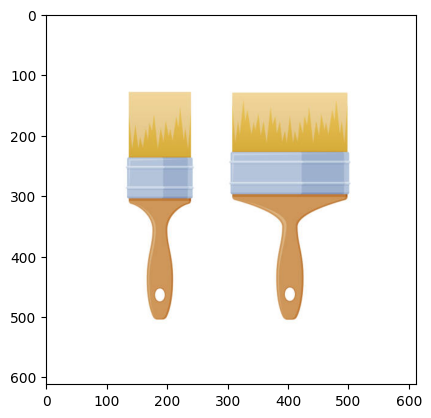

In [ ]:
# visualize an example
idx = np.random.choice(dataset_train.shape[0])
print(dataset_train[idx]['adjective'])
print(dataset_train[idx]['antonym'])
plt.imshow(dataset_train[idx]['image'])

In [ ]:
# load the prompts
with open('/content/drive/MyDrive/685_dataset/all_prompts.json', 'r') as f:
    all_prompts = json.load(f)

print("Example prompt:")
rand_adj = random.choice(list(all_prompts.keys()))
print(f"adjective: {rand_adj}, prompts_dict: {all_prompts[rand_adj]}")

Example prompt:
adjective: balder, prompts_dict: {'abstract_noun': 'hairiness', 'ai': ['The image contains two objects that can be compared based on their hairiness.', 'Two objects are present in the image that can be distinguished based on their hairiness.', 'There are a pair of objects in the image that differ in hairiness and can be compared.', 'Two objects can be observed in the image and compared on the basis of their relative hairiness.', 'The image displays two objects that have a discernible difference in hairiness.', 'Both objects in the image can be compared using the adjective balder.', 'There exist two objects in the image which can be distinguished by the degree of hairiness.', 'A comparison can be made between the two objects in the image based on their hairiness.', 'The image depicts two objects, and their relative hairiness can be used for comparison.', 'By using the adjective balder, the two objects in the image can be differentiated.', 'A comparison of the objects in 

In [ ]:
# load the annotations to see
train_df = pd.read_csv("/content/drive/MyDrive/685_dataset/all_labels_aug.csv")
train_df['image_name'] = train_df['image_name'] + ".jpg"
train_df.head(10)

,image_name,adjective_1,adjective_2
0,p_0.jpg,bigger,smaller
1,p_1.jpg,cleaner,dirtier
2,p_2.jpg,hairier,balder
3,p_3.jpg,younger,older
4,p_5.jpg,colder,hotter
5,p_6.jpg,taller,shorter
6,p_7.jpg,harder,softer
7,p_8.jpg,drier,wetter
8,p_9.jpg,nearer,farther
9,p_11.jpg,fatter,skinnier


In [ ]:
# Load Adjectives (No None)
adjectives_list = train_df['adjective_1'].tolist()
gt_list = adjectives_list
# Load Antonyms (Does have None)
antonyms_list = train_df['adjective_2'].tolist()
# create antonym --> adjective dict
ant_to_adj = {k: v for k, v in zip(antonyms_list, adjectives_list)}
ant_to_adj.pop("None")

adjectives_list = list(set(adjectives_list))
antonyms_list = set(antonyms_list)
antonyms_list.remove("None")
antonyms_list = list(antonyms_list)
unique_adjectives = adjectives_list + antonyms_list
print(f"{len(adjectives_list)=}, {len(antonyms_list)=}, {len(unique_adjectives)=}")
adj_to_idx = {k: v for v,k in enumerate(adjectives_list)}
ant_to_idx = {k: v+len(adjectives_list) for v,k in enumerate(antonyms_list)}
antidx_to_adjidx = {ant_to_idx[ant]: adj_to_idx[ant_to_adj[ant]] for ant in antonyms_list}

len(adjectives_list)=39, len(antonyms_list)=30, len(unique_adjectives)=69


In [ ]:
# # Load Adjectives (No None)
# adjectives_list = train_df['adjective_1'].tolist()
# # Load Antonyms (Does have None)
# antonyms_list = train_df['adjective_2'].tolist()
# # create the adjective to antonym dictionary
# adj_to_ant = {k:v for k, v in zip(adjectives_list, antonyms_list)}
# ant_to_adj = {k:v for v, k in adj_to_ant.items()}
# ant_to_adj.pop("None")
# # Unique Adjectives
# unique_adjectives = set(adjectives_list + antonyms_list)
# unique_adjectives.remove("None")
# unique_adjectives = list(unique_adjectives)
# print(f"{len(unique_adjectives)=}")
# # adjective index mapping
# adj_to_idx = {k:v for v, k in enumerate(unique_adjectives)}
# idx_to_adj = {k:v for v, k in adj_to_idx.items()}

len(unique_adjectives)=69


## Modeling

In [ ]:
model_name = "openai/clip-vit-base-patch32"
# model_name = "openai/clip-vit-large-patch14"
model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device).eval()

In [ ]:
class CLIPWrapper:
    def __init__(self, clip_model, clip_processor, adjectives, prompts):
        self.clip_model = clip_model
        self.clip_processor = clip_processor
        self.adjectives = adjectives
        self.prompts = prompts

    def __call__(self, dataset):
        texts = self.prompts
        imgs = [data['image'] for data in dataset]
        filenames = [data['filename'] for data in dataset]
        true_labels = [data['adjective'] for data in dataset]
        inputs = self.clip_processor(text=texts, images=imgs, return_tensors="pt", padding=True).to(device)
        with torch.no_grad():
            outputs = self.clip_model(**inputs)
        logits_per_image = outputs.logits_per_image
        probs = logits_per_image.softmax(dim=-1)
        # return probs, labels
        return probs, true_labels, filenames

In [ ]:
# run on all human prompts
prompt_format = 'human'  # 'ai'
num_prompts = {'human': 6, 'ai': 93}[prompt_format]
top_1_accuracies = []
top_5_accuracies = []
for i in tqdm(range(num_prompts), desc="# Prompts"):
    input_prompts = [all_prompts[adj][prompt_format][i] for adj in adjectives_list]
    clipper = CLIPWrapper(model, processor, unique_adjectives, input_prompts)
    probs, true_labels, filenames = clipper(dataset_train)
    y_true = [adjectives_list.index(adj) for adj in true_labels]
    top_1_accuracies.append(top_k_accuracy_score(y_true, probs.cpu().numpy(), k=1))
    top_5_accuracies.append(top_k_accuracy_score(y_true, probs.cpu().numpy(), k=5))

In [ ]:
# print statistics
min_top1_acc, max_top1_acc = np.min(top_1_accuracies), np.max(top_1_accuracies)
mean_top1_acc, std_top1_acc = np.mean(top_1_accuracies), np.std(top_1_accuracies)
min_top5_acc, max_top5_acc = np.min(top_5_accuracies), np.max(top_5_accuracies)
mean_top5_acc, std_top5_acc = np.mean(top_5_accuracies), np.std(top_5_accuracies)
min_top1_idx, max_top1_idx = np.argmin(top_1_accuracies), np.argmax(top_1_accuracies)
min_top5_idx, max_top5_idx = np.argmin(top_5_accuracies), np.argmax(top_5_accuracies)
min_top1_prompt = all_prompts['thicker'][prompt_format][min_top1_idx]
max_top1_prompt = all_prompts['thicker'][prompt_format][max_top1_idx]
min_top5_prompt = all_prompts['thicker'][prompt_format][min_top5_idx]
max_top5_prompt = all_prompts['thicker'][prompt_format][max_top5_idx]

print(f"{min_top1_acc=:.4f}, {max_top1_acc=:.4f}, {mean_top1_acc=:.4f}, {std_top1_acc=:.4f},")
print(f"{min_top5_acc=:.4f}, {max_top5_acc=:.4f}, {mean_top5_acc=:.4f}, {std_top5_acc=:.4f},")
print(f"min top-1,5 accuracy prompts: \n {min_top1_prompt, min_top5_prompt}")
print(f"max top-1,5 accuracy prompts: \n {max_top1_prompt, max_top5_prompt}")

min_top1_acc=0.1790, max_top1_acc=0.2257, mean_top1_acc=0.1991, std_top1_acc=0.0173,
min_top5_acc=0.3969, max_top5_acc=0.4747, mean_top5_acc=0.4351, std_top5_acc=0.0257,
min top-1,5 accuracy prompts: 
 ('thickness can be used to compare the objects in the image', 'There are two objects in the image. They can be compared using the adjective thicker.')
max top-1,5 accuracy prompts: 
 ('The objects in the image can be compared using the adjective "thicker"', 'The object on one side is thicker than the object on the other side.')


In [ ]:
# run on all ai prompts
prompt_format = 'ai'
num_prompts = {'human': 6, 'ai': 93}[prompt_format]
top_1_accuracies = []
top_5_accuracies = []
for i in tqdm(range(num_prompts), desc="# Prompts"):
    input_prompts = [all_prompts[adj][prompt_format][i] for adj in adjectives_list]
    clipper = CLIPWrapper(model, processor, unique_adjectives, input_prompts)
    probs, true_labels, filenames = clipper(dataset_train)
    y_true = [adjectives_list.index(adj) for adj in true_labels]
    top_1_accuracies.append(top_k_accuracy_score(y_true, probs.cpu().numpy(), k=1))
    top_5_accuracies.append(top_k_accuracy_score(y_true, probs.cpu().numpy(), k=5))

# Prompts:   2%|▏         | 2/93 [01:24<1:03:42, 42.00s/it]


KeyboardInterrupt: ignored

In [ ]:
# print statistics
min_top1_acc, max_top1_acc = np.min(top_1_accuracies), np.max(top_1_accuracies)
mean_top1_acc, std_top1_acc = np.mean(top_1_accuracies), np.std(top_1_accuracies)
min_top5_acc, max_top5_acc = np.min(top_5_accuracies), np.max(top_5_accuracies)
mean_top5_acc, std_top5_acc = np.mean(top_5_accuracies), np.std(top_5_accuracies)
min_top1_idx, max_top1_idx = np.argmin(top_1_accuracies), np.argmax(top_1_accuracies)
min_top5_idx, max_top5_idx = np.argmin(top_5_accuracies), np.argmax(top_5_accuracies)
min_top1_prompt = all_prompts['thicker'][prompt_format][min_top1_idx]
max_top1_prompt = all_prompts['thicker'][prompt_format][max_top1_idx]
min_top5_prompt = all_prompts['thicker'][prompt_format][min_top5_idx]
max_top5_prompt = all_prompts['thicker'][prompt_format][max_top5_idx]

print(f"{min_top1_acc=:.4f}, {max_top1_acc=:.4f}, {mean_top1_acc=:.4f}, {std_top1_acc=:.4f},")
print(f"{min_top5_acc=:.4f}, {max_top5_acc=:.4f}, {mean_top5_acc=:.4f}, {std_top5_acc=:.4f},")
print(f"min top-1,5 accuracy prompts: \n {min_top1_prompt, min_top5_prompt}")
print(f"max top-1,5 accuracy prompts: \n {max_top1_prompt, max_top5_prompt}")

In [ ]:
input_prompts = [all_prompts[adj]['human'][-1] for adj in adjectives_list]
# input_prompts = [f"The objects in this image can be compared using the adjective '{k}'" for k in unique_adjectives]
# input_prompts = unique_adjectives
print(f"{len(input_prompts)=}")

len(input_prompts)=69


In [ ]:
input_prompts[0]

'riper'

In [ ]:
clipper = CLIPWrapper(model, processor, unique_adjectives, input_prompts)

In [ ]:
tic = time.time()
probs, true_labels, filenames = clipper(dataset_train)
toc = time.time()
print(f"Time taken: {toc-tic:.2f}s")

Time taken: 35.18s


In [ ]:
filenames[0], true_labels[0], probs[0]

('l_23',
 'flatter',
 tensor([0.1001, 0.0093, 0.0035, 0.0032, 0.0117, 0.0072, 0.0492, 0.0145, 0.0135,
         0.0237, 0.1093, 0.0242, 0.0026, 0.0013, 0.0116, 0.0121, 0.0017, 0.0018,
         0.0145, 0.0036, 0.0424, 0.0096, 0.0055, 0.0123, 0.0036, 0.0004, 0.0146,
         0.0449, 0.0097, 0.0014, 0.0018, 0.0009, 0.0014, 0.0002, 0.0070, 0.0016,
         0.0055, 0.0016, 0.0031, 0.0066, 0.0144, 0.0008, 0.0065, 0.0081, 0.0165,
         0.0008, 0.0046, 0.0324, 0.0085, 0.0018, 0.0083, 0.0012, 0.0088, 0.0049,
         0.0067, 0.0238, 0.0105, 0.0017, 0.0141, 0.0150, 0.0476, 0.0013, 0.0549,
         0.0104, 0.0110, 0.0399, 0.0037, 0.0018, 0.0469], device='cuda:0'))

In [ ]:
for j, adj_idx in antidx_to_adjidx.items():
    probs[:, adj_idx] += probs[:, j]
probs_collapsed = probs[:, :len(adjectives_list)]

In [ ]:
probs_collapsed.shape

torch.Size([257, 39])

In [ ]:
y_true = [adjectives_list.index(adj) for adj in true_labels]

In [ ]:
top_1_acc = top_k_accuracy_score(y_true, probs_collapsed.cpu().numpy(), k=1)
top_5_acc = top_k_accuracy_score(y_true, probs_collapsed.cpu().numpy(), k=5)
print(f"{top_1_acc=:.4f}, {top_5_acc=:.4f}")

top_1_acc=0.2257, top_5_acc=0.4436


In [ ]:
top_probs, top_idxs = probs.topk(39, dim=-1)

In [ ]:
top_adjs = [[unique_adjectives[i] for i in idxs] for idxs in top_idxs]

In [ ]:
len(top_adjs), len(top_adjs[0])

(257, 39)

In [ ]:
labels = indices.cpu().numpy()

In [ ]:
labels_adj = [[idx_to_adj[i] for i in x] for x in labels]

In [ ]:
top_1 = 0
top_5 = 0
for i, item in enumerate(dataset_train):
    # print(f"GT: {item['adjective']}, {item['antonym']}\t pred: {labels_sided[i]}")
    if item['adjective'] == labels_sided[i][0]:
        top_1 += 1
    elif item['adjective'] in labels_sided[i]:
        top_5 += 1

num_samples = dataset_train.shape[0]
print(f"Top 1 acc: {top_1:.2f}, Top 5 acc: {top_5:.2f}")

Top 1 acc: 53.00, Top 5 acc: 55.00


In [ ]:
labels_sided = labels_adj.copy()
for i, x in enumerate(labels_adj):
    for j, adj in enumerate(x):
        if adj in adj_to_ant:
            continue
        else:
            labels_sided[i][j] = ant_to_adj[adj]

In [ ]:
num_samples

257